# Data exploration

In this notebook we explore the MovieLens 100K dataset and get some ideas about data preprocessing

## Setup

In [ ]:
import os

if os.path.basename(os.getcwd()) == 'notebooks':
    %cd ..

In [2]:
from src.data.load_data import read_data, read_item_data, read_user_data, get_genre_names

from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import pandas as pd

In [3]:
def interp_plot(xs, ys, amount=10):
    Xs = np.interp(np.linspace(0, len(xs) - 1, len(xs) * amount), range(len(xs)), xs)
    Ys = np.interp(np.linspace(0, len(ys) - 1, len(ys) * amount), range(len(ys)), ys)

    return Xs, Ys

def convolve_plot(xs, ys, wsize=10):
    window = np.ones(wsize) / wsize
    return xs[wsize - 1 - (wsize // 2):-(wsize // 2)], np.convolve(ys, window, mode='valid')

## Explore general data

Load the `u.data` file in the dataframe:

In [4]:
df = read_data()
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Check indexing of `user_id` and `item_id`:

In [5]:
print((df['user_id'] == 0).value_counts(), end='\n\n')
print((df['item_id'] == 0).value_counts())

user_id
False    100000
Name: count, dtype: int64

item_id
False    100000
Name: count, dtype: int64


There are no 0th user or 0th item, apparently the indexing starts from 1:

In [6]:
print(df['user_id'].min())
print(df['item_id'].min())

1
1


Check that there are no missed ids (i.e. there is a user 1 and a user 3, but no user 2):

In [7]:
print(len(df['user_id'].unique()) == df['user_id'].max())
print(len(df['item_id'].unique()) == df['item_id'].max())

True
True


The ids are indexed from 1, but other than that they are ok. The only preprocessing we need to apply is to subtract 1 from all user and item ids to arrive at 0-based indexing

The dataset consists of 943 users and 1682 movies. Let's see the distributions:

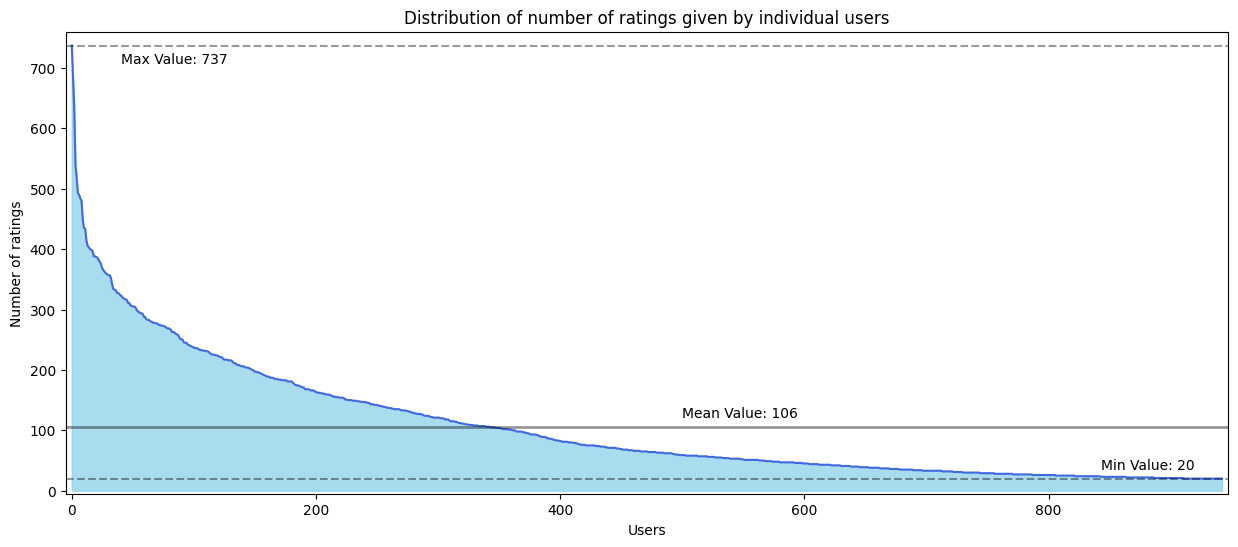

In [8]:
user_counts = df['user_id'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(15, 6))
plt.fill_between(range(len(user_counts)), user_counts.values, color='skyblue', alpha=0.7)
plt.plot(range(len(user_counts)), user_counts.values, color='royalblue')
plt.xlabel('Users')
plt.ylabel('Number of ratings')
plt.title('Distribution of number of ratings given by individual users')
plt.xlim(-5, len(user_counts) + 4)
plt.ylim(-5, 760)

min_value = user_counts.min()
plt.axhline(y=min_value, color='k', linestyle='--', lw=1.5, alpha=0.4)
plt.text(len(user_counts) - 100, min_value + 15, f'Min Value: {min_value}', color='k')

max_value = user_counts.max()
plt.axhline(y=max_value, color='k', linestyle='--', lw=1.5, alpha=0.4)
plt.text(40, max_value - 30, f'Max Value: {max_value}', color='k')

mean_value = user_counts.mean()
plt.axhline(y=mean_value, color='k', lw=2, alpha=0.4)
plt.text(500, mean_value + 15, f'Mean Value: {mean_value:0.0f}', color='k')

plt.show()

The plot above shows the distribution of number of rated movies by each of the users. Each user has rated at leats 20 movies, and the most active user has rated 737. We can see that in general there are more people with less ratings, and less people with high number of ratings

Mean rating: 3.53


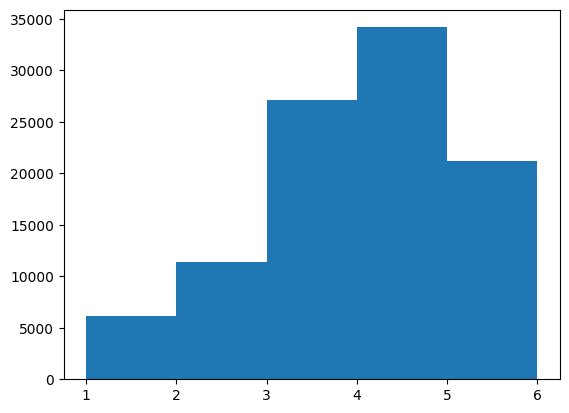

In [9]:
_ = df['rating'].hist(grid=False, bins=range(1, 7))
print(f'Mean rating: {df["rating"].mean():0.2f}')

Here is a distribution of ratings. The most picked rating seems to be 4, while the rarest rating is 1. Due to heavy disbalance of ratings the mean rating in the dataset is 3.53, which might be a possibility for nomalization (e.g. shift mean to 3.0)

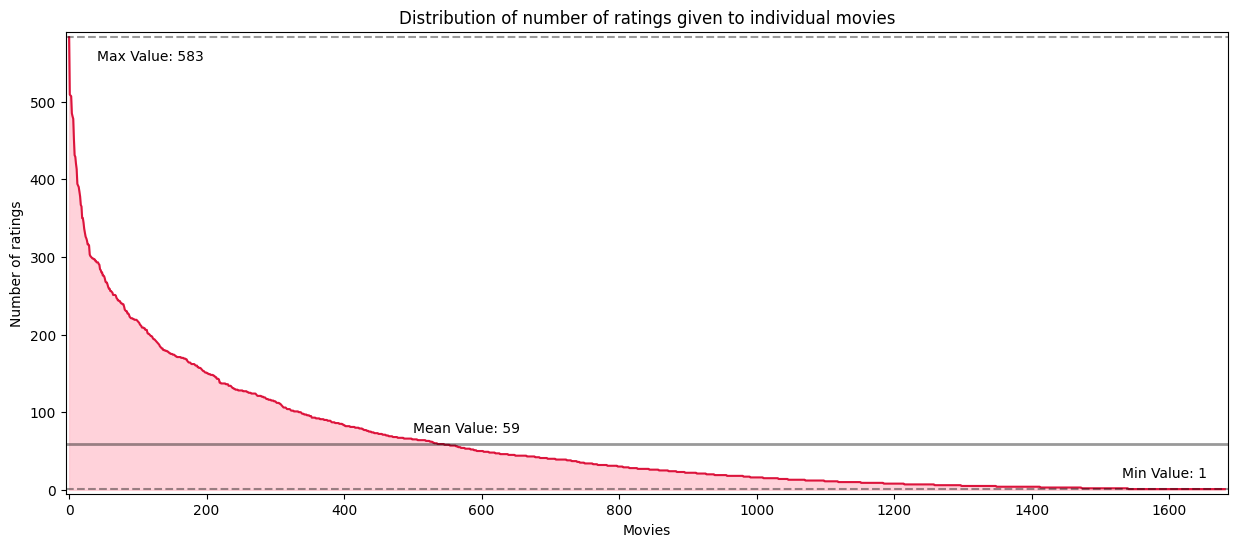

In [10]:
movie_counts = df['item_id'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(15, 6))
plt.fill_between(range(len(movie_counts)), movie_counts.values, color='pink', alpha=0.7)
plt.plot(range(len(movie_counts)), movie_counts.values, color='crimson')
plt.xlabel('Movies')
plt.ylabel('Number of ratings')
plt.title('Distribution of number of ratings given to individual movies')
plt.xlim(-5, len(movie_counts) + 4)
plt.ylim(-5, 590)

min_value = movie_counts.min()
plt.axhline(y=min_value, color='k', linestyle='--', lw=1.5, alpha=0.4)
plt.text(len(movie_counts) - 150, min_value + 15, f'Min Value: {min_value}', color='k')

max_value = movie_counts.max()
plt.axhline(y=max_value, color='k', linestyle='--', lw=1.5, alpha=0.4)
plt.text(40, max_value - 30, f'Max Value: {max_value}', color='k')

mean_value = movie_counts.mean()
plt.axhline(y=mean_value, color='k', lw=2, alpha=0.4)
plt.text(500, mean_value + 15, f'Mean Value: {mean_value:0.0f}', color='k')

plt.show()

The plot above demostrates the number of ratings for each of the movies. We can see that there are movies that only have a single rating, which might make it tough to recommend these movies to anyone. Nevertheless, the mean value of ratings per movies is 59, which should be plenty for our purposes.

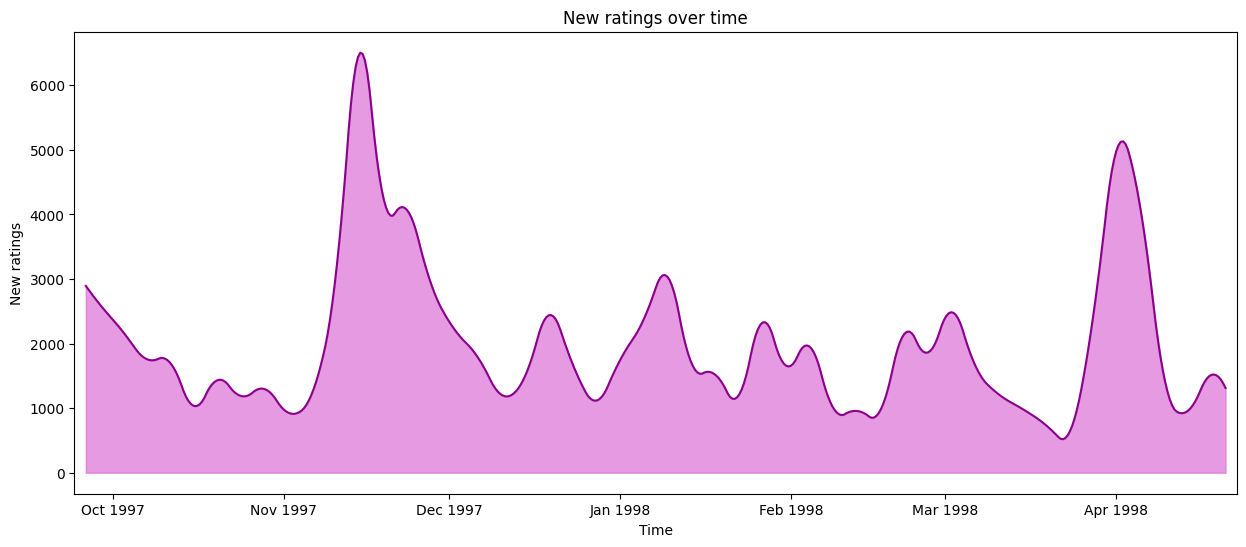

In [11]:
timestamps = df['timestamp'].to_numpy()
counts, bin_edges = np.histogram(timestamps, bins=50)
bin_edges, counts = interp_plot(bin_edges[1:], counts)
dates = [datetime.utcfromtimestamp(ts) for ts in bin_edges]
xs, activity_over_time = convolve_plot(dates, counts)

plt.figure(figsize=(15, 6))
plt.fill_between(xs, activity_over_time, color='orchid', alpha=0.7)
plt.plot(xs, activity_over_time, color='darkmagenta')
plt.margins(x=0.01)
plt.xlabel('Time')
plt.ylabel('New ratings')
plt.title('New ratings over time')
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))

The plot above visualizes the number of new ratings appering over time. While the plot is not 100% flat, the time span is less than a year, which suggests that there are less reasons to even consider the temporal information. E.g. it is uncommon for people tastes to change drastically over such short period of time, so we can assume that if a user liked a movie in the past, they will still like it in the present. 

## User data

Let's take a look at user data now.

In [12]:
udf = read_user_data()
udf.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


Intuitevely, all of the columns might be helpful for the algorithm in one way or another. `zip_code` column is probably the least useful one, but it can be used to identify the place of residence of the users, which may or may not be important. Passing zip code directly in the model might not be the best approach, since zip codes have hierarchical structure and most of the time a zip code consists of three parts: ABCDE -> A, BC, DE. Splitting the numerical string into these 3 parts may help model make sense of the zip code. Another option would be to use some kind of embeddings, which would adjust automatically to the zip code structure. Moreover, embeddings may be able to handle 'unique' zip codes, that don't follow the usual rules.

Now let's look at users distribution:

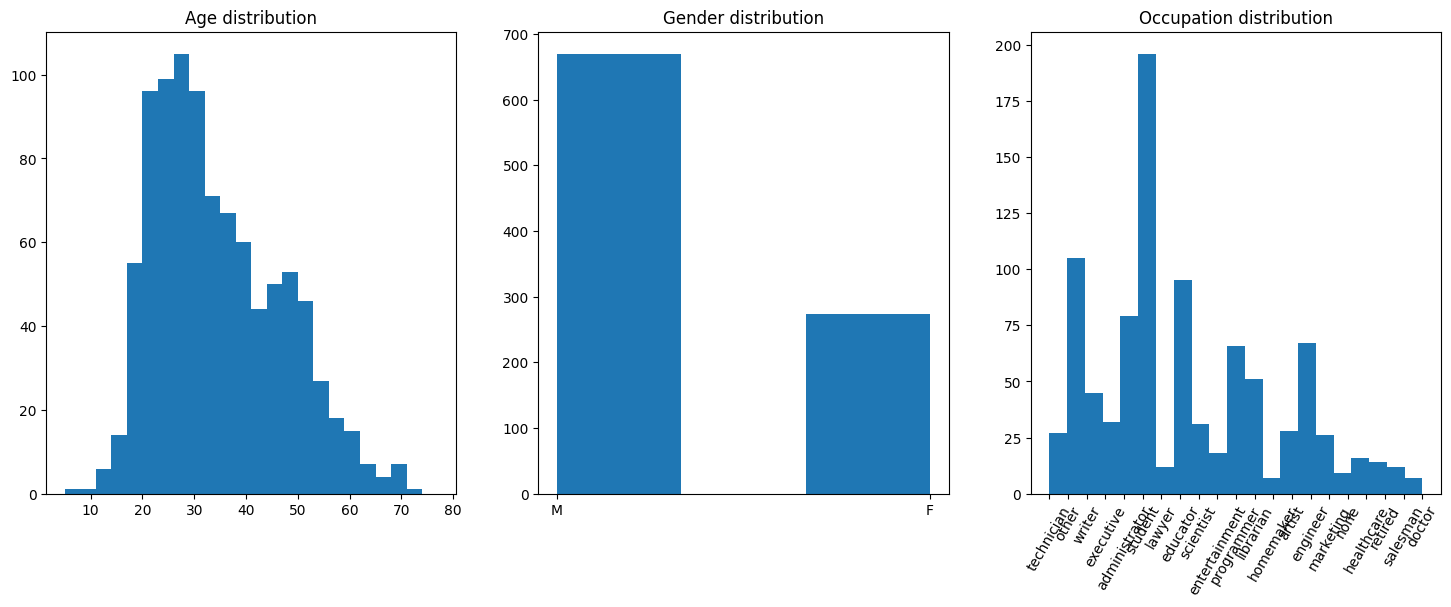

In [13]:
ax = plt.subplots(1, 3, figsize=(18, 6))[1].ravel()
udf.age.hist(bins=range(5, 80, 3), ax=ax[0], grid=False)
udf.gender.hist(bins=3, ax=ax[1], grid=False)
udf.occupation.hist(bins=21, ax=ax[2], grid=False)
ax[0].set_title('Age distribution')
ax[1].set_title('Gender distribution')
ax[2].set_title('Occupation distribution')
ax[2].tick_params(axis='x', rotation=60) 
plt.show()

Nothing too notable here: we see that the distribution is once again unbalanced with dominating groups: males, students, age [20 - 35]

Let's also see whether some of the demographic information affect actual ratings. Let's start with gender:

In [14]:
male_ids = udf['user_id'][udf['gender'] == 'M']
female_ids = udf['user_id'][udf['gender'] == 'F']

male_entries = df[df['user_id'].isin(male_ids)]
female_entries = df[df['user_id'].isin(female_ids)]

male_top50 = male_entries.groupby(male_entries['item_id'])['rating'].mean().sort_values(ascending=False).head(50)
female_top50 = female_entries.groupby(female_entries['item_id'])['rating'].mean().sort_values(ascending=False).head(50)

In [15]:
fm_inter = set(male_top50.index).intersection(set(female_top50.index))
print(f'Common entries for top-50 rated movies amoung male vs. female: {len(fm_inter)}/50')

Common entries for top-50 rated movies amoung male vs. female: 11/50


Here we separated male and female ratings and separetely found top 50 movies (by mean rating) for each group. It appears that only 11 movies (22%) are shared between these two lists. That tells us that there is a significant difference in ratings between males and females, hence the gender info will be useful for the model to better predict the recommendations.

In [16]:
under35_ids = udf['user_id'][udf['age'] < 35]
over35_ids = udf['user_id'][udf['age'] >= 35]

under35_entries = df[df['user_id'].isin(under35_ids)]
over35_entries = df[df['user_id'].isin(over35_ids)]

under35_top50 = under35_entries.groupby(under35_entries['item_id'])['rating'].mean().sort_values(ascending=False).head(50)
over35_top50 = over35_entries.groupby(over35_entries['item_id'])['rating'].mean().sort_values(ascending=False).head(50)

In [17]:
yo_inter = set(under35_top50.index).intersection(set(over35_top50.index))
print(f'Common entries for top-50 rated movies amoung groups `under 35` vs. `35 and older`: {len(yo_inter)}/50')

Common entries for top-50 rated movies amoung groups `under 35` vs. `35 and older`: 9/50


Here we divided the users in 2 groups again: those who are younger than 35 y.o., and those who are at least 35. This time we got 9 (18%) out of 50 movies contained in both top-50 lists, indicating that preferences in terms of movies can vary greatly with age. The split under 35 / over 35 is somewhat arbitrary, but it shows that age matters as well.

## Movies data

Let's load data about items:

In [18]:
idf = read_item_data()
idf.head()

,movie_id,title,release_date,video_release_date,url,0,1,2,3,4,...,9,10,11,12,13,14,15,16,17,18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


`video_release_date` column seems to be empty, and if that's the case, we can safely remove it from consideraion:

In [19]:
idf['video_release_date'].unique()

array([nan])

Indeed, we have no useful information in this column hence we can remove it. 

I have not been able to come up with a use for the `url` column, so we drop it as well.

The `title` column could be used, since certain info can be extracted from the movie's title. However I will not be considering the title as a useful column, since while there is a possibility to get some data from it, it might prove very difficult to enhance model's prediction based on title. Especially since we still have info about movie genres, which should be way easier to interpret and use for prediction. 

In [20]:
idf = idf.drop(columns=['video_release_date', 'url', 'title'], errors='ignore')
idf.head()

,movie_id,release_date,0,1,2,3,4,5,6,7,...,9,10,11,12,13,14,15,16,17,18
0,1,01-Jan-1995,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,01-Jan-1995,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,01-Jan-1995,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,01-Jan-1995,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,01-Jan-1995,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


While `release_date` column will probably not affect the model's performance much, we can still keep it. The date may be converted to a single number e.g. unix timestamp, and passed to the model. Since unix timestamps are really large numbers, they should be somehow reduced. The easiest way is to divide them by some number, like 86400, to reduce timestamp resolution from seconds to days (I don't see a reason to why we would need such precision anyway). The second thing we can do is use standardization on the timestamps. This will leave us with decent timestamp representation to capture temporal dynamics: positive numbers represent latest events, near-zero are somewhere in the middle of the dataset, and negative numbers represent old events. In should be noted though that standardization may distort meaning of timestamps in undesireable ways. An alternative to standardization is usual normalization.

The last columns we have are genre columns. These are 19 columns that have 0 or 1, depending on whether a movie belongs to a genre or not. Let's explore these columns:

In [21]:
idf[[str(x) for x in range(19)]].sum(axis=1).value_counts()

1    833
2    569
3    215
4     51
5     11
6      3
Name: count, dtype: int64

As we can see, some of the movies do belong to multiple genres, up to 6.

In [22]:
genre_names = get_genre_names()
genre_counts = idf[[str(x) for x in range(19)]].sum(axis=0)

pd.DataFrame(np.array([genre_names['genre_name'], genre_counts]).T, columns=['genre_name', 'number_of_movies']).sort_values('number_of_movies', ascending=False)

,genre_name,number_of_movies
8,Drama,725
5,Comedy,505
1,Action,251
16,Thriller,251
14,Romance,247
2,Adventure,135
4,Children's,122
6,Crime,109
15,Sci-Fi,101
11,Horror,92


Here are the number of movies grouped by genres they belong to. Here we can see a classic case of class imbalance, with Drama movies comprising almost a half of dataset, whereas there are only 22 Fantasy movies.